<h1>Applying weighted loss function in time series forecasting</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

import sys
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

plt.style.use('dark_background')

# Define weigths

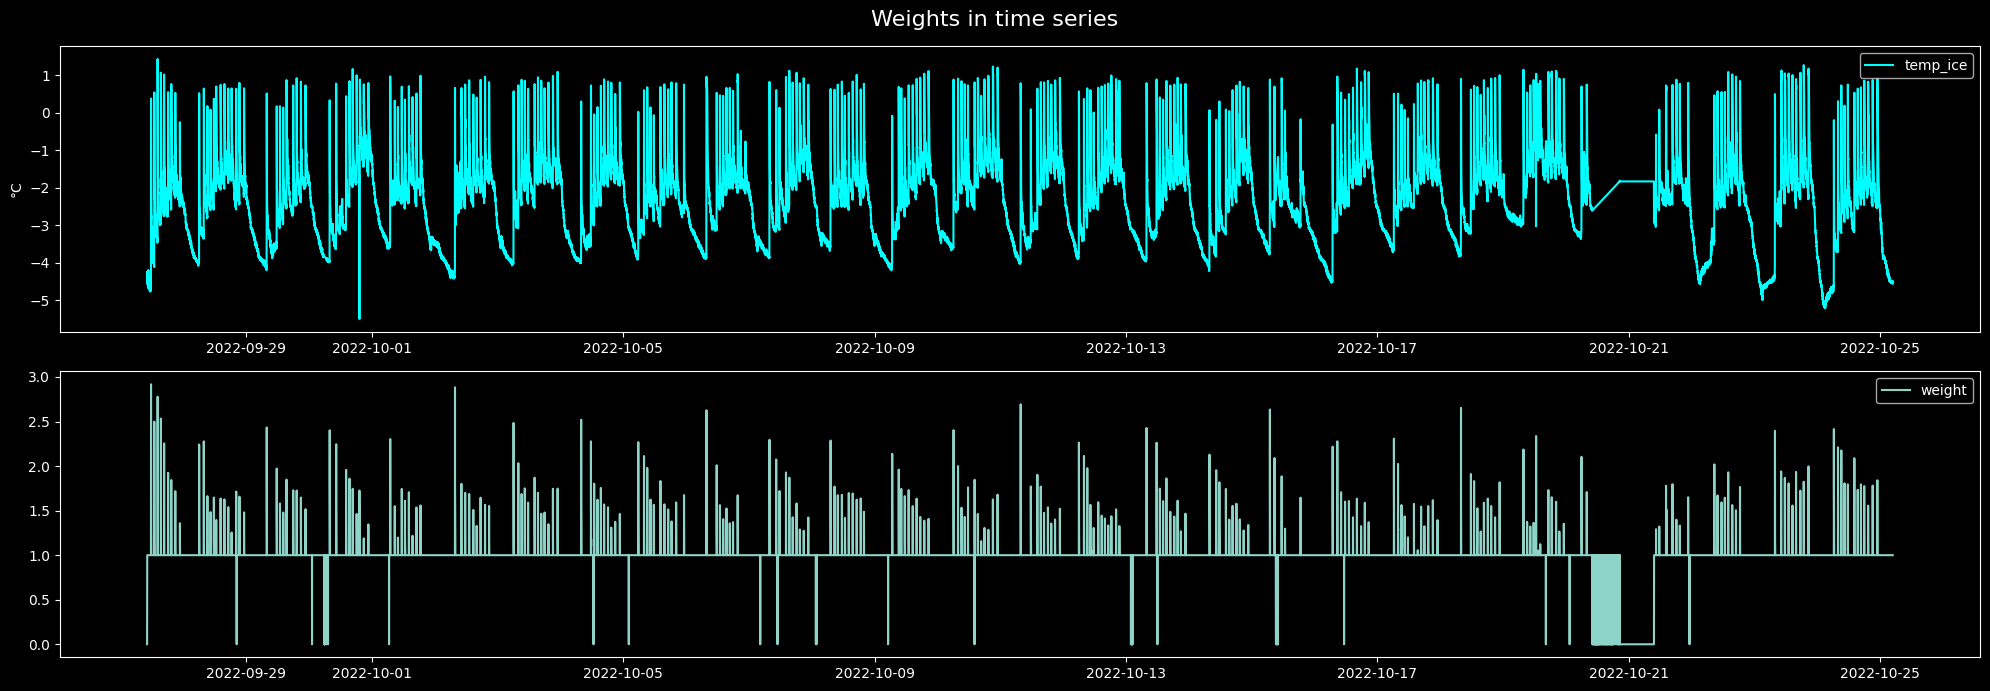

In [2]:
df = pd.read_csv('../data/small_data.csv')
df['time'] = pd.to_datetime(df['time'])

df['diff'] = df['temp_ice'].diff(1)
df['diff_1'] = df['diff'].diff(1) 
df['diff_2'] = df['diff'].diff(2) 
df['diff_3'] = df['diff'].diff(3)
df['weight'] = df['temp_ice'].diff(2).abs().ewm(span=4).mean().fillna(0)

df['weight'] = np.where((df['diff_1'] == df['diff_2']) & (df['diff_1'] == df['diff_3']), 0, df['weight'])
df['weight'] = np.where((df['weight'] < 1) & (df['weight'] != 0), 1, df['weight'])

# Visualize weights
plt.figure(figsize=(20, 7))
plt.suptitle('Weights in time series', fontsize=16)

plt.subplot(2, 1, 1)
plt.plot(df['time'], df['temp_ice'], label='temp_ice', color='cyan')
plt.ylabel('°C')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(df['time'], df['weight'], label='weight')
plt.ylabel('')
plt.legend()

plt.tight_layout()
plt.show()

# Creating a data loader

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, path, seq_length, step_size, split='train', train_size=0.7, val_size=0.15, scaler=None):
        '''
        Args:
            path (str): path to csv file with data
            seq_length (int): sequence length for input data
            step_size (int): steps count forward for prediction (horizon)
            split (str): type of sample ('train', 'val', 'test')
            train_size (float): data proportion for train sample
            val_size (float): data proportion for val sample -> test_size = 1 - train_size - val_size
            scaler (sklearn.preprocessing)
        '''
        
        cols = ['time', 'temp_ice', 'temp_inside', 'temp_outside', 'hum_inside', 'hum_outside']
        self.data = pd.read_csv(path, usecols=cols)
        self.seq_length = seq_length
        self.step_size = step_size
        self.scaler = scaler

        self.data['time'] = pd.to_datetime(self.data['time'])
        self.data['min_sin'] = np.sin(2 * np.pi * self.data['time'].dt.minute / 60)
        self.data['min_cos'] = np.cos(2 * np.pi * self.data['time'].dt.minute / 60)
        self.data['hour_sin'] = np.sin(2 * np.pi * self.data['time'].dt.hour / 24)
        self.data['hour_cos'] = np.cos(2 * np.pi * self.data['time'].dt.hour / 24)
        self.data['dow_sin'] = np.sin(2 * np.pi * self.data['time'].dt.day_of_week / 7)
        self.data['dow_cos'] = np.cos(2 * np.pi * self.data['time'].dt.day_of_week / 7)

        self.data['diff'] = self.data['temp_ice'].diff(1).fillna(0)

        self.features = ['temp_ice', 'temp_inside', 'temp_outside', 'hum_inside', 'hum_outside', 
                         'min_sin', 'min_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'diff']
        
        self.scaler_features = ['temp_ice', 'temp_inside', 'temp_outside', 'hum_inside', 'hum_outside', 'diff']

        # split train, validation and test sampling
        n = len(self.data)
        train_end = int(n * train_size)
        val_end = train_end + int(n * val_size)

        if split == 'train':
            self.data = self.data[:train_end]
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.data[self.scaler_features])
        elif split == 'val':
            self.data = self.data[train_end:val_end]
        elif split == 'test':
            self.data = self.data[val_end:]
        else:
            raise ValueError('split must be "train", "val" or "test"')

        if self.scaler is not None:
            self.data[self.scaler_features] = self.scaler.transform(self.data[self.scaler_features])
        else:
            raise ValueError('Scaler not defined, create a train_dataset instance for it')
        
        # calculate weights
        self._calculate_weights()
        self.data = self.data.fillna(0)

    def __len__(self):
        return len(self.data) - self.seq_length - self.step_size + 1
    

    def __getitem__(self, idx):
        x = self.data.iloc[idx: idx + self.seq_length][self.features].values
        y = self.data.iloc[idx + self.seq_length + self.step_size - 1]['temp_ice']
        w = self.data.iloc[idx + self.seq_length + self.step_size - 1]['weight']

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(w, dtype=torch.float32)
    

    def _calculate_weights(self):
        self.data['diff_1'] = self.data['diff'].diff(1) 
        self.data['diff_2'] = self.data['diff'].diff(2) 
        self.data['diff_3'] = self.data['diff'].diff(3)
        self.data['weight'] = self.data['temp_ice'].diff(2).abs().ewm(span=4).mean().fillna(0)

        self.data['weight'] = np.where((self.data['diff_1'] == self.data['diff_2']) & (self.data['diff_1'] == self.data['diff_3']), 0, self.data['weight'])
        self.data['weight'] = np.where((self.data['weight'] < 1) & (self.data['weight'] != 0), 1, self.data['weight'])

    

path = '../data/small_data.csv'
seq_length = 60
step_size = 30
batch_size = 32

train_dataset = TimeSeriesDataset(path, seq_length, step_size, split='train', train_size=0.7, val_size=0.15)
val_dataset = TimeSeriesDataset(path, seq_length, step_size, split='val', train_size=0.7, val_size=0.15, scaler=train_dataset.scaler)
test_dataset = TimeSeriesDataset(path, seq_length, step_size, split='test', train_size=0.7, val_size=0.15, scaler=train_dataset.scaler)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Creating a model

In [31]:
class SimpleRNN(nn.Module):
    def __init__(self, seq_length, num_features, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(seq_length * num_features, hidden_size, num_layers, batch_first=True)
        self.linear_1 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x, _ = self.rnn(x, h0)
        x = self.linear_1(x[:, -1, :])
        return x



def weighted_mse_loss(w, y_pred, y):
    return (w * (y_pred - y)**2).mean()


num_features = len(train_dataset.features)
hidden_size = 64

model = SimpleRNN(seq_length, num_features, hidden_size, 1).to(device)
mse_loss_model = weighted_mse_loss
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

In [30]:
num_layers = 1
hidden_size = 32
tensor = torch.rand([seq_length, num_features], dtype=torch.float32)
h0 = torch.zeros(num_layers, seq_length * num_features, hidden_size)

print(h0.shape, tensor.shape)
model.rnn(tensor, h0)

torch.Size([1, 720, 32]) torch.Size([60, 12])


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

In [17]:
str_info = '''
class SimpleRNN(nn.Module):
    def __init__(self, seq_length, num_features, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(seq_length * num_features, hidden_size, num_layers, batch_first=True)
        self.linear_1 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.linear_1(out[:, -1, :])
        return x



def weighted_mse_loss(w, y_pred, y):
    return (w * (y_pred - y)**2).mean()'''

EPOCHS = 50
save_epoch = 0
train_loss = []
train_metric = []
val_loss = []
val_metric = []
lr_list = []
best_loss = None
features = train_dataset.features

checkpoint = {
    'info': str_info,
    'features': features,
    'seq_length': seq_length,
    'hidden_size': hidden_size,
    'state_model': model.state_dict(),
    'state_opt': opt.state_dict(),
    'state_lr_scheduler': lr_scheduler.state_dict(),
    'loss': {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_loss': best_loss
    },
    'metric': {
        'train_metric': train_metric,
        'val_metric': val_metric
    },
    'lr': 'lr_list',
    'epoch': {
        'EPOCHS': EPOCHS,
        'save_epoch': save_epoch
    }
}

# Train model

In [18]:
# training cycle
for epoch in range(save_epoch, EPOCHS):

    # model training
    model.train()
    running_train_loss = []
    running_train_metric = []
    train_loop = tqdm(train_loader, leave=False, file=sys.stdout)
    for X, y, w in train_loop:
        # (batch_size, seq_length)
        X = X.reshape(batch_size, seq_length * num_features).to(device)
        y = y.reshape(batch_size, -1).to(device)
        w = w.reshape(batch_size, -1).to(device)

        # forward + calculation loss
        y_pred = model(X)
        mse_loss = mse_loss_model(w, y_pred, y)
        mae_metric = torch.abs(y_pred - y).mean()

        # backward
        opt.zero_grad()
        mse_loss.backward()
    
        # optimization step
        opt.step()


        running_train_loss.append(mse_loss.item())
        running_train_metric.append(mae_metric.item())

        mean_train_loss = sum(running_train_loss) / len(running_train_loss)
        mean_train_metric = sum(running_train_metric) / len(running_train_metric)

        train_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss={mean_train_loss:.4f}')
    
    
    train_loss.append(mean_train_loss)
    train_metric.append(mean_train_metric)

    # model validating
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        running_val_metric = []
        for X, y, w in val_loader:
            X = X.reshape(batch_size, seq_length * num_features).to(device)
            y = y.reshape(batch_size, -1).to(device)
            w = w.reshape(batch_size, -1).to(device)

            # forward
            y_pred = model(X)
            mse_loss = mse_loss_model(w, y_pred, y)
            mae_metric = torch.abs(y_pred - y).mean()

            running_val_loss.append(mse_loss.item())
            running_val_metric.append(mae_metric.item())

            mean_val_loss = sum(running_val_loss) / len(running_val_loss)
            mean_val_metric = sum(running_val_metric) / len(running_val_metric)
        
        val_loss.append(mean_val_loss)
        val_metric.append(mean_val_metric)
        

    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f'Epoch [{epoch + 1}/{EPOCHS}], ' 
          f'train_loss={mean_train_loss:.4f}, train_metric={mean_train_metric:.4f}, '
          f'val_loss={mean_val_loss:.4f}, val_metric={mean_train_metric:.4f}')


    if best_loss is None or (best_loss - mean_val_loss) / best_loss > 0.01:
        best_loss = mean_val_loss
        count = 0

        checkpoint = {
            'info': str_info,
            'features': features,
            'state_model': model.state_dict(),
            'state_opt': opt.state_dict(),
            'state_lr_scheduler': lr_scheduler.state_dict(),
            'loss': {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_loss': best_loss
            },
            'metric': {
                'train_metric': train_metric,
                'val_metric': val_metric
            },
            'lr': lr_list,
            'epoch': {
                'EPOCHS': EPOCHS,
                'save_epoch': epoch
            }
        }

        torch.save(checkpoint, f'../models/simple_rnn_checkpoint.pt')
        print(f'On epoch - {epoch + 1}, the model with the value of the validation loss function is saved - {mean_val_loss:.4f}', end='\n\n')
    else:
        count += 1

    if count >= 10:
        print(f'\033[31m Training stopped at epoch {epoch + 1}.\033[0m')
        break

RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

# Model check

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [71]:
load_model_state = torch.load('../models/weighted_enhanced_dnn_model_checkpoint.pt', map_location=torch.device(device))

In [72]:
load_model_state.keys()

dict_keys(['info', 'features', 'state_model', 'state_opt', 'state_lr_scheduler', 'loss', 'metric', 'lr', 'epoch'])

In [73]:
train_loss = load_model_state['loss']['train_loss']
val_loss = load_model_state['loss']['val_loss']
train_metric = load_model_state['metric']['train_metric']
val_metric = load_model_state['metric']['val_metric']
lr_list = load_model_state['lr']
features = load_model_state['features']

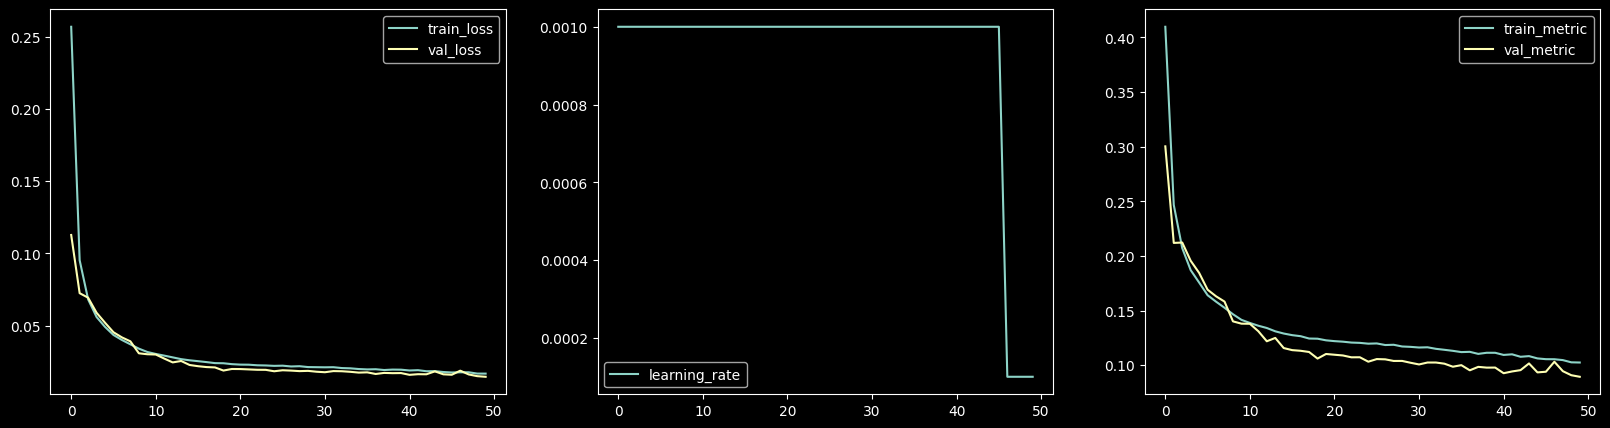

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(train_loss)
ax1.plot(val_loss)
ax1.legend(['train_loss', 'val_loss'])

ax2.plot(lr_list)
ax2.legend(['learning_rate'])

ax3.plot(train_metric)
ax3.plot(val_metric)
ax3.legend(['train_metric', 'val_metric'])

In [74]:
class EnhancedDnnModel(nn.Module):
    def __init__(self, seq_length, num_features, output_size):
        super().__init__()
        self.seq_length = seq_length
        self.num_features = num_features
        
        self.linear_1 = nn.Linear(seq_length * num_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.linear_2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.linear_3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.5)

        self.linear_4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.5)
        
        self.linear_5 = nn.Linear(32, 16)
        self.bn5 = nn.BatchNorm1d(16)
        self.dropout5 = nn.Dropout(0.5)

        self.linear_6 = nn.Linear(16, output_size)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.linear_1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout1(x)
        
        x = self.linear_2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout2(x)
        
        x = self.linear_3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.dropout3(x)
        
        x = self.linear_4(x)
        x = self.bn4(x)
        x = self.act(x)
        x = self.dropout4(x)

        x = self.linear_5(x)
        x = self.bn5(x)
        x = self.act(x)
        x = self.dropout5(x)
        
        x = self.linear_6(x)
        
        return x



def weighted_mse_loss(w, y_pred, y):
    return (w * (y_pred - y)**2).mean()

def weighted_mse_loss(w, y_pred, y):
    return (w * (y_pred - y)**2).mean()


seq_length = 60
num_features = len(features)
model = EnhancedDnnModel(seq_length, num_features, 1).to(device)
mse_loss_model = weighted_mse_loss

# model.load_state_dict(load_model_state['state_model'])
model.load_state_dict(checkpoint['state_model'])

<All keys matched successfully>

In [75]:
y_lst = []
y_pred_lst = []

model.eval()
with torch.no_grad():
    running_test_loss = []
    running_test_metric = []
    for X, y , w in test_loader:
        X = X.reshape(batch_size, seq_length * num_features).to(device)
        y = y.reshape(batch_size, -1).to(device)
        w = w.reshape(batch_size, -1).to(device)

        y_pred = model(X)
        mse_loss = mse_loss_model(w, y_pred, y)
        mae_metric = torch.abs(y_pred - y).mean()

        running_test_loss.append(mse_loss.item())
        running_test_metric.append(mae_metric.item())

        y_lst.extend(torch.squeeze(y).tolist())
        y_pred_lst.extend(torch.squeeze(y_pred).tolist())


    mean_test_loss = sum(running_test_loss) / len(running_test_loss)
    mean_test_metric = sum(running_test_metric) / len(running_test_metric)

    print(f'test_loss={mean_test_loss:.4f}, test_metric={mean_test_metric:.4f}')

test_loss=0.0472, test_metric=0.1865


In [76]:
y = np.array(y_lst).reshape(-1, 1)
y_pred = np.array(y_pred_lst).reshape(-1, 1)

size_scaler_features = len(test_dataset.scaler_features) - 1
size_scaler_features = len(test_dataset.scaler_features) - 1
zeros_matrix = np.zeros((len(y), size_scaler_features))

y = test_dataset.scaler.inverse_transform(np.concatenate([y, zeros_matrix], axis=1))[:, [0]]
y_pred = test_dataset.scaler.inverse_transform(np.concatenate([y_pred, zeros_matrix], axis=1))[:, [0]]

In [77]:
# y = train_dataset.scaler.inverse_transform(y)[:, [0]].reshape(-1, 1)
# y_pred = train_dataset.scaler.inverse_transform(y_pred)[:, [0]].reshape(-1, 1)

In [78]:
result_df = pd.DataFrame({'temp_ice': y.flatten(), 'pred_temp_ice': y_pred.flatten()})[-2 * 1440:]
# result_df = pd.DataFrame({'temp_ice': y.flatten(), 'pred_temp_ice': y_pred.flatten()})

In [79]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [80]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=test_dataset.data['time'], y=result_df['temp_ice'], name='Температура льда'), row=1, col=1)
fig.add_trace(go.Scatter(x=test_dataset.data['time'], y=result_df['pred_temp_ice'], name='Прогноз'), row=1, col=1)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                #   width=1000,
                  height=800,
                  font_color="#837A4F",
                  title_font_color="#837A4F")
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Температура: %{y:.2f}°C', row=1, col=1)
fig.update_yaxes(title_text='°C', row=1, col=1)

In [ ]:
fig.show('jpg', width=2000, height=1000)